## Dependencies Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import os

c:\Users\aurel\anaconda3\envs\ULiege\lib\site-packages\torchvision\io\image.py:14: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\aurel\anaconda3\envs\ULiege\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Hyperparameter Configuration

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

BATCH_SIZE = 128
EPOCHS = 10
LR = 0.001
LR_SCHEDULER_FACTOR = 0.5
LR_SCHEDULER_PATIENCE = 3
DATA_DIR = "../data_tensors_10000"
OUTPUT_DIR = "../models/model_big_10000.pt"

Using device: cuda


## Define Transform for the Data

In [3]:
# This is not used with the current dataset, as it is already in tensor format

transform = transforms.Compose([
	#transforms.Grayscale(),
	transforms.ToTensor(),
	transforms.Normalize((0.5,), (0.5,))
])

## Dataset Setup

In [4]:
# Load all .npy files from "data_npy", assume each file is one class
data_dir = DATA_DIR
class_files = sorted(f for f in os.listdir(data_dir) if f.endswith(".npy"))
all_data, all_labels = [], []

for label_idx, fname in enumerate(class_files):
    arr = np.load(os.path.join(data_dir, fname))       # shape (N, H, W)
    arr = arr[:, None, :, :]   # add channel dimension (N, 1, H, W)
    all_data.append(arr)
    all_labels.append(np.full(arr.shape[0], label_idx))

all_data = np.concatenate(all_data, axis=0)             # (total_samples, C, H, W)
all_labels = np.concatenate(all_labels, axis=0)         # (total_samples,)

# Create a TensorDataset
dataset = TensorDataset(torch.from_numpy(all_data).float(), torch.from_numpy(all_labels).long())

In [5]:
# Directory containing the .pt files, one per class
data_dir = DATA_DIR
class_files = sorted(f for f in os.listdir(data_dir) if f.endswith(".pt"))

all_data, all_labels = [], []

for label_idx, fname in enumerate(class_files):
    # Load the tensor that contains all the samples for this class
    tensor = torch.load(os.path.join(data_dir, fname))  # shape: (N, C, H, W)    
    all_data.append(tensor)
    # Create a label vector of the same size
    labels = torch.full((tensor.size(0),), label_idx, dtype=torch.long)
    all_labels.append(labels)

# Concatenate all classes into a single large tensor
all_data   = torch.cat(all_data,   dim=0)  # (total_samples, C, H, W)
all_labels = torch.cat(all_labels, dim=0)  # (total_samples,)

# Create the TensorDataset
dataset = TensorDataset(all_data.float(), all_labels)


C:\Users\aurel\AppData\Local\Temp\ipykernel_5148\637969883.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(os.path.join(data_dir, fname))  # shape: (

In [6]:
num_classes = len(class_files)
print(f"Number of classes: {num_classes}")

# Split into train/val/test
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size   = int(0.1 * total_size)
test_size  = total_size - train_size - val_size

print(f"Total size: {total_size}")
print(f"Train: {train_size}\t Val: {val_size}\t Test: {test_size}")

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoader parameters
NUM_WORKERS = 7

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)


with open("../all_classes.txt", "r") as f:
    CLASSES = [line.strip() for line in f]
# Show the shape of one sample from the dataset
for images, labels in test_loader:
    print(f"Image batch shape: {images.size()}")
    print(f"Label batch shape: {labels.size()}")
    # Show the first image and label
    print("Example image:")
    plt.imshow(images[0, 0].cpu().numpy(), cmap='gray')
    plt.title(f"Label: {CLASSES[labels[0].item()]}")
    plt.axis('off')
    plt.show()
    break

Number of classes: 345
Total size: 3450000
Train: 2415000	 Val: 345000	 Test: 690000
Image batch shape: torch.Size([128, 1, 28, 28])
Label batch shape: torch.Size([128])


## Model Definition

In [7]:
class SimpleCNN(nn.Module):
	def __init__(self, num_classes=10):
		super().__init__()
		self.conv1 = nn.Conv2d(1, 32, 3)
		self.pool = nn.MaxPool2d(2)
		self.conv2 = nn.Conv2d(32, 64, 3)
		self.fc1 = nn.Linear(64 * 5 * 5, 128)
		self.fc2 = nn.Linear(128, num_classes)
		
	def forward(self, x):
		x = self.pool(F.relu(self.conv1(x)))
		x = self.pool(F.relu(self.conv2(x)))
		x = x.view(-1, 64 * 5 * 5)
		x = F.relu(self.fc1(x))
		return self.fc2(x)


class BiggerCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        with torch.no_grad():
            dummy = torch.zeros(1, 1, 28, 28)
            out = self.pool(F.relu(self.conv2(F.relu(self.conv1(dummy)))))
            out = self.pool(F.relu(self.conv4(F.relu(self.conv3(out)))))
            self.flattened_size = out.view(1, -1).size(1)

        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        return self.fc2(x)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super().__init__()
        stride = 2 if downsample else 1
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        if downsample or in_channels != out_channels:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.residual = nn.Identity()

    def forward(self, x):
        identity = self.residual(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return F.relu(out)

class QuickDrawCNN(nn.Module):
    def __init__(self, num_classes=345):
        super().__init__()
        # Stem
        self.stem = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        # Bloques residuales
        self.layer1 = self._make_layer(64, 128, num_blocks=2, downsample=True)
        self.layer2 = self._make_layer(128, 256, num_blocks=2, downsample=True)
        self.layer3 = self._make_layer(256, 512, num_blocks=2, downsample=True)
        # Clasificador
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(p=0.5)
        self.fc      = nn.Linear(512, num_classes)

        # Inicialización
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, in_c, out_c, num_blocks, downsample):
        layers = []
        layers.append(ResidualBlock(in_c, out_c, downsample=downsample))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_c, out_c))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)          # [N, 64, 28, 28]
        x = self.layer1(x)        # [N,128,14,14]
        x = self.layer2(x)        # [N,256,7,7]
        x = self.layer3(x)        # [N,512,4,4] (gracias al padding)
        x = self.avgpool(x)       # [N,512,1,1]
        x = torch.flatten(x, 1)   # [N,512]
        x = self.dropout(x)
        logits = self.fc(x)       # [N,345]
        return logits


## Training

In [8]:
def evaluate_model(model, loader, criterion, device):
    model.eval()
    losses, correct, total = [], 0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            losses.append(loss.item())
            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    avg_loss = np.mean(losses)
    accuracy = correct / total
    return avg_loss, accuracy

In [ ]:
model = QuickDrawCNN(num_classes=num_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=LR_SCHEDULER_FACTOR, patience=LR_SCHEDULER_PATIENCE, verbose=True)

# Training loop
def train_cnn(num_epochs):
    print("Starting training...")

    train_loss_history, val_loss_history, val_accuracy_history = [], [], []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_losses = []
        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            train_losses.append(loss.item())
            loss.backward()
            optimizer.step()

        avg_train_loss = np.mean(train_losses)
        train_loss_history.append(avg_train_loss)
        
        # Validation
        avg_val_loss, accuracy = evaluate_model(model, val_loader, criterion, DEVICE)

        val_loss_history.append(avg_val_loss)
        val_accuracy_history.append(accuracy)

        # Adjust learning rate
        scheduler.step(avg_val_loss)

        # Print statistics
        print(f"Epoch {epoch+1}/{num_epochs}\t Train Loss: {avg_train_loss:.4f}\t Validation Loss: {avg_val_loss:.4f}\t Validation Accuracy: {accuracy:.4f}")

    print("Training complete.")
    # Save the model
    torch.save(model.state_dict(), OUTPUT_DIR)
    return train_loss_history, val_loss_history, val_accuracy_history

train_losses, val_losses, val_accuracies = train_cnn(EPOCHS)

c:\Users\aurel\anaconda3\envs\ULiege\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting training...
Epoch 1/10	 Train Loss: 2.7839	 Validation Loss: 1.8695	 Validation Accuracy: 0.5645
Epoch 2/10	 Train Loss: 2.3055	 Validation Loss: 1.7463	 Validation Accuracy: 0.5946
Epoch 3/10	 Train Loss: 2.1855	 Validation Loss: 1.6779	 Validation Accuracy: 0.6046
Epoch 4/10	 Train Loss: 2.1302	 Validation Loss: 1.6612	 Validation Accuracy: 0.6103
Epoch 5/10	 Train Loss: 2.0943	 Validation Loss: 1.6434	 Validation Accuracy: 0.6138
Epoch 6/10	 Train Loss: 2.0699	 Validation Loss: 1.6223	 Validation Accuracy: 0.6181
Epoch 7/10	 Train Loss: 2.0507	 Validation Loss: 1.6023	 Validation Accuracy: 0.6206
Epoch 8/10	 Train Loss: 2.0393	 Validation Loss: 1.6089	 Validation Accuracy: 0.6197
Epoch 9/10	 Train Loss: 2.0290	 Validation Loss: 1.5972	 Validation Accuracy: 0.6245
Epoch 10/10	 Train Loss: 2.0191	 Validation Loss: 1.5929	 Validation Accuracy: 0.6226
Training complete.


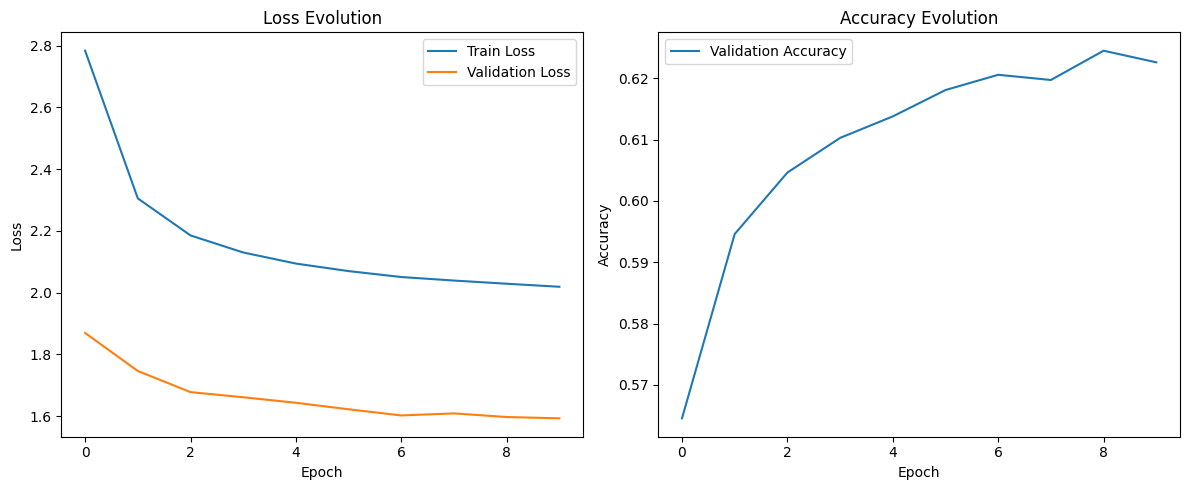

In [10]:
# Plot the results
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Evolution")
plt.legend()
plt.tight_layout()
plt.show()

## Test

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

with open("../all_classes.txt", "r") as f:
    CLASSES = [line.strip() for line in f]

model.eval()

total = 0
correct = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# cm = confusion_matrix(all_labels, all_preds)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
# disp.plot(xticks_rotation=45, cmap="Blues")
# plt.tight_layout()
# plt.show()

Test Accuracy: 62.31%
